In [9]:
import os
import math
import xarray as xr
import numpy as np
import geopandas as gpd

import clima_anom as ca

from scipy.stats import spearmanr

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

In [10]:
# product, resolution, yy_s, yy_e = 'IMERG', '01x01', 2001, 2023
# product, resolution, yy_s, yy_e = 'IMERG', '025x025', 2001, 2023
product, resolution, yy_s, yy_e = 'CMORPH', '025x025', 1998, 2023

yys_cut = 2001
yye_cut = 2023

In [11]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Weibull')
dir_shape = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

In [12]:
veneto_dir = os.path.join(dir_shape,'Veneto.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [13]:
if product == 'IMERG' and resolution == '025x025':
    data_dir = os.path.join(dir_base,f'VENETO_WEIBULL_{product}_{resolution}_{yy_s}_{yy_e}.nc')
else:
    data_dir = os.path.join(dir_base,f'VENETO_WEIBULL_{product}_{yy_s}_{yy_e}.nc')

print(f'Product load: {data_dir}')
DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yys_cut,yye_cut+1)]))
DATA_time = DATA['time'].values
lat, lon = DATA['lat'].values, DATA['lon'].values
lon2d, lat2d = np.meshgrid(lon, lat)

Product load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_CMORPH_1998_2023.nc


In [14]:
if product == 'IMERG' and resolution == '025x025':
    OBS_dir = os.path.join(dir_base,f'VENETO_WEIBULL_OBS_{product}_{resolution}_1981_2023.nc')
else:
    OBS_dir = os.path.join(dir_base,f'VENETO_WEIBULL_OBS_{product}_1981_2023.nc')

print(f'OBS load: {data_dir}')
OBS = xr.open_dataset(OBS_dir)
OBS = OBS.sel(time=OBS.time.dt.year.isin([np.arange(yys_cut,yye_cut+1)]))

OBS_time = OBS['time'].values

OBS load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_CMORPH_1998_2023.nc


In [15]:
def CORR_2d(DATA1, DATA2):
    
    if DATA1.shape[0] != DATA2.shape[0] or DATA1.shape[1] != DATA2.shape[1]:
        print('ERROR diferents dimension')
        return 0

    CORR_ = np.empty((DATA1.shape[1], DATA1.shape[2]))
    for i in range(DATA1.shape[1]):
        for j in range(DATA1.shape[2]):
            data1 = DATA1[:, i, j]
            data2 = DATA2[:, i, j]
            if np.isnan(data1).all() or np.isnan(data2).all():
                CORR_[i, j] = np.nan
            else:
                correlation, _ = spearmanr(data1, data2, nan_policy='omit')
                CORR_[i, j] = correlation

    return CORR_

def RMSE_2d(DATA1, DATA2):
    """
    Calculate the RMSE for 2D spatial data arrays across the time dimension.
    
    Parameters:
    DATA1, DATA2 : numpy.ndarray
        Arrays with the same shape (time, lat, lon).
    
    Returns:
    RMSE_ : numpy.ndarray
        A 2D array (lat, lon) containing the RMSE values.
    """
    if DATA1.shape != DATA2.shape:
        print('ERROR: Different dimensions')
        return None

    # Initialize the RMSE array
    RMSE_ = np.empty((DATA1.shape[1], DATA1.shape[2]))

    # Loop through each spatial point (lat, lon)
    for i in range(DATA1.shape[1]):
        for j in range(DATA1.shape[2]):
            data1 = DATA1[:, i, j]
            data2 = DATA2[:, i, j]

            # Check for all NaN values
            if np.isnan(data1).all() or np.isnan(data2).all():
                RMSE_[i, j] = np.nan
            else:
                # Compute RMSE ignoring NaN values
                valid_idx = ~np.isnan(data1) & ~np.isnan(data2)
                squared_diff = (data1[valid_idx] - data2[valid_idx]) ** 2
                RMSE_[i, j] = np.sqrt(np.mean(squared_diff))

    return RMSE_

def round_down_to_nearest_10(number):
    return (number // 10) * 10

def round_up_to_nearest_10(number):
    return math.ceil(number / 10) * 10

In [16]:
mask = ~np.isnan(np.nanmean(OBS['Wetdays'].values,axis=0))

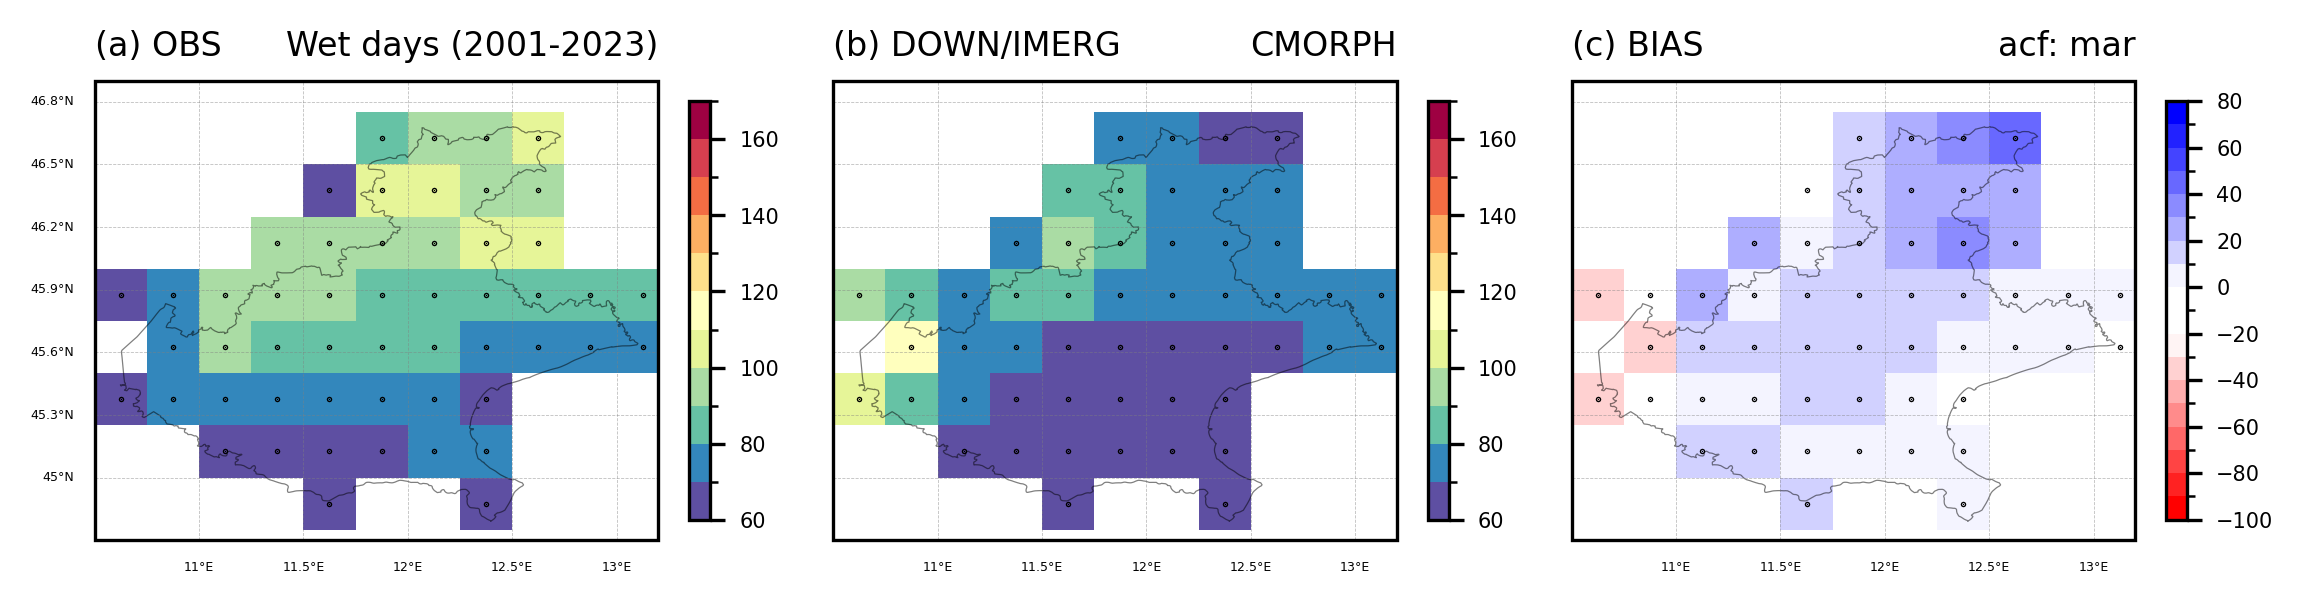

In [17]:
OBS_mean = np.nanmean(OBS['Wetdays'].values,axis=0)
DOWN_mean = np.nanmean(DATA['DOWN_WD'].values,axis=0)

levels_wd = np.arange(60,180,10)
norm_wd = mcolors.BoundaryNorm(boundaries=levels_wd, ncolors=256)

levels_diff = np.arange(-100,90,10)
norm_diff = mcolors.BoundaryNorm(boundaries=levels_diff, ncolors=256)

cmap_wd = plt.cm.Spectral_r
cmpa_diff = plt.cm.bwr_r
cmpa_diff = ca.colorbar_middle_white(cmpa_diff)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,3)

# ======================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, OBS_mean, cmap=cmap_wd, norm=norm_wd)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(a) OBS', fontsize=8, loc='left')
ax1.set_title(f'Wet days ({yys_cut}-{yye_cut})', fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, DOWN_mean, cmap=cmap_wd, norm=norm_wd)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(b) DOWN/IMERG', fontsize=8, loc='left')
ax1.set_title(product, fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, OBS_mean-DOWN_mean, cmap=cmpa_diff, norm=norm_diff)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(c) BIAS', fontsize=8, loc='left')
ax1.set_title('acf: mar', fontsize=8, loc='right')

# ======================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.2)

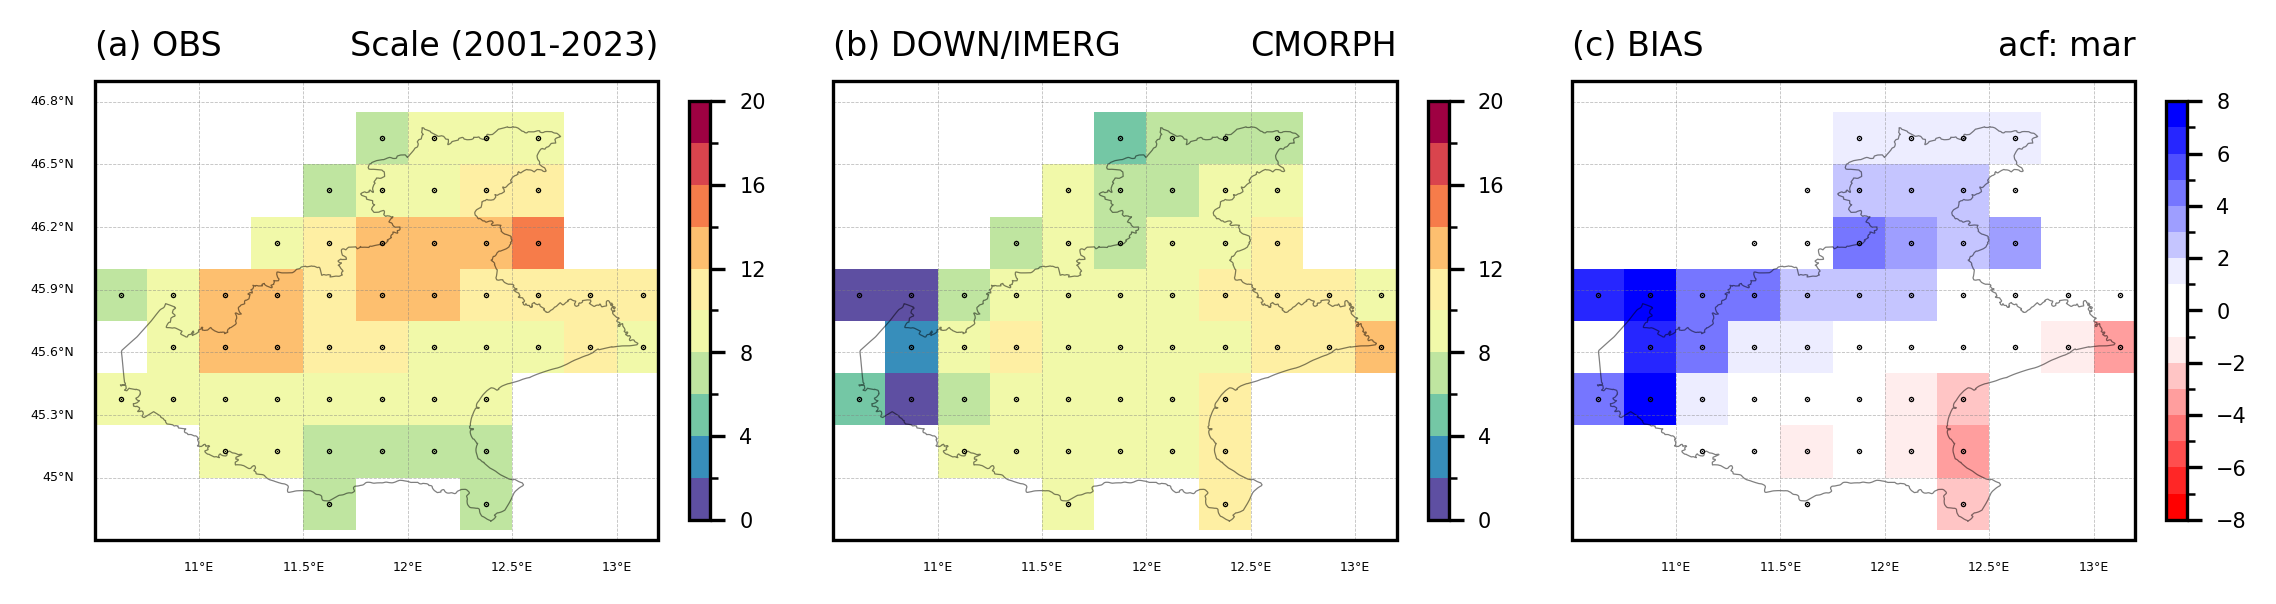

In [18]:
OBS_mean = np.nanmean(OBS['Scale'].values,axis=0)
DOWN_mean = np.nanmean(DATA['DOWN_SC'].values,axis=0)

val_min = round_down_to_nearest_10(np.min([np.nanmin(OBS_mean), np.nanmin(DOWN_mean)]))
val_max = round_up_to_nearest_10(np.max([np.nanmax(OBS_mean), np.nanmax(DOWN_mean)]))

levels_wd = np.arange(val_min,val_max+2,2)
norm_wd = mcolors.BoundaryNorm(boundaries=levels_wd, ncolors=256)

levels_diff = np.arange(-8,9,1)
norm_diff = mcolors.BoundaryNorm(boundaries=levels_diff, ncolors=256)

cmap_wd = plt.cm.Spectral_r
cmpa_diff = plt.cm.bwr_r
cmpa_diff = ca.colorbar_middle_white(cmpa_diff)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,3)

# ======================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, OBS_mean, cmap=cmap_wd, norm=norm_wd)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(a) OBS', fontsize=8, loc='left')
ax1.set_title(f'Scale ({yys_cut}-{yye_cut})', fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, DOWN_mean, cmap=cmap_wd, norm=norm_wd)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(b) DOWN/IMERG', fontsize=8, loc='left')
ax1.set_title(product, fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, OBS_mean-DOWN_mean, cmap=cmpa_diff, norm=norm_diff)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(c) BIAS', fontsize=8, loc='left')
ax1.set_title('acf: mar', fontsize=8, loc='right')

# ======================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.2)

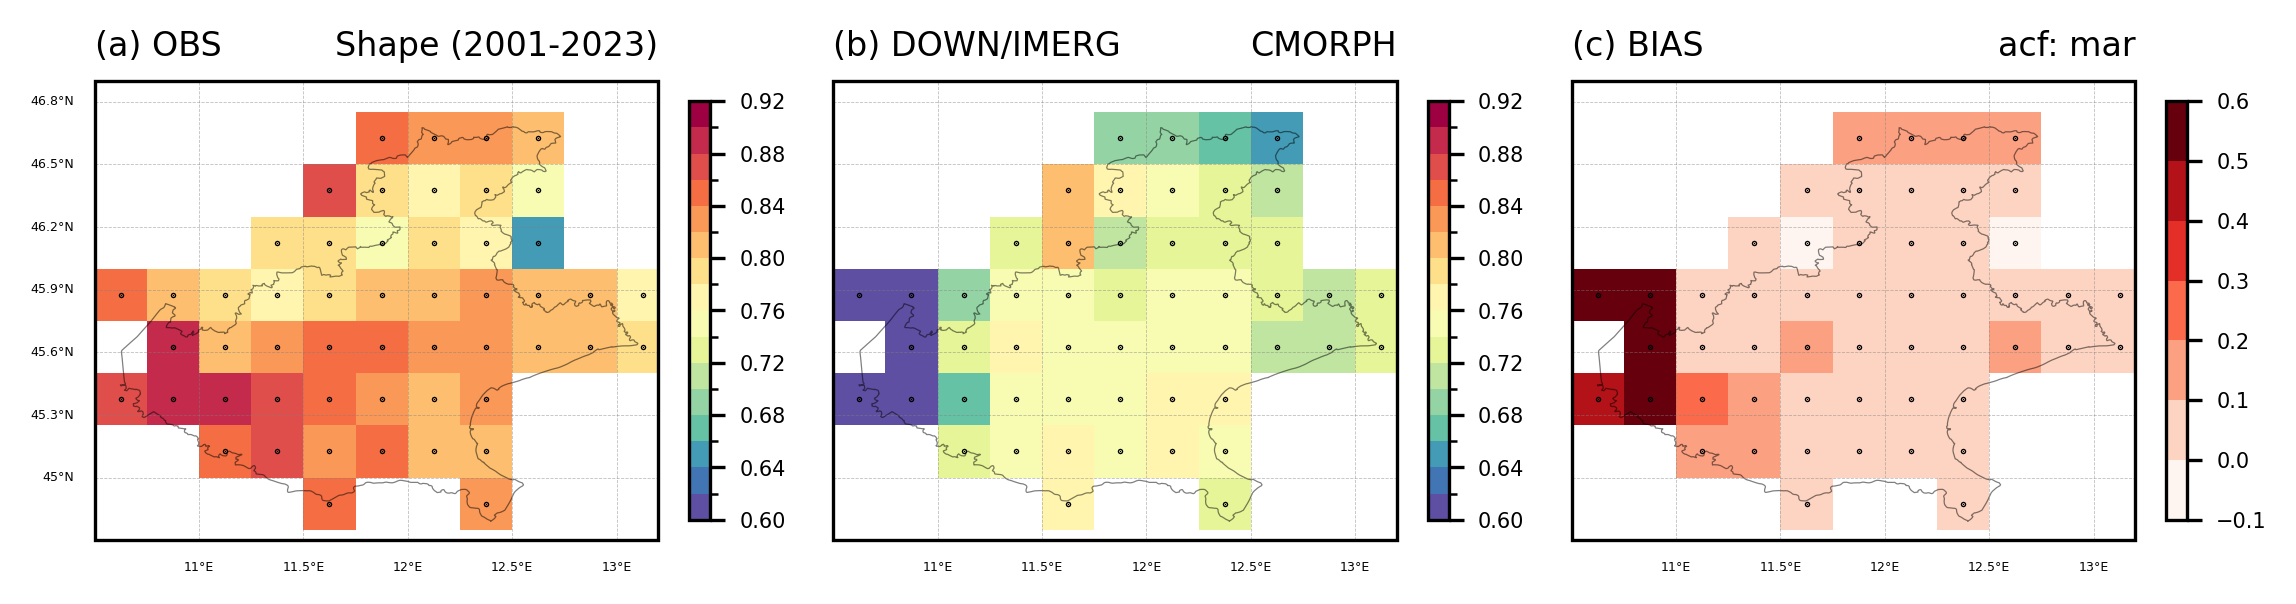

In [19]:
OBS_mean = np.nanmean(OBS['Shape'].values,axis=0)
DOWN_mean = np.nanmean(DATA['DOWN_SH'].values,axis=0)

levels_wd = np.arange(0.6,0.9+0.02,0.02)
norm_wd = mcolors.BoundaryNorm(boundaries=levels_wd, ncolors=256)

levels_diff = np.arange(-0.1,0.7,0.1)
norm_diff = mcolors.BoundaryNorm(boundaries=levels_diff, ncolors=256)

cmap_wd = plt.cm.Spectral_r
cmpa_diff = plt.cm.Reds

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,3)

# ======================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, OBS_mean, cmap=cmap_wd, norm=norm_wd)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(a) OBS', fontsize=8, loc='left')
ax1.set_title(f'Shape ({yys_cut}-{yye_cut})', fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, DOWN_mean, cmap=cmap_wd, norm=norm_wd)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(b) DOWN/IMERG', fontsize=8, loc='left')
ax1.set_title(product, fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, OBS_mean-DOWN_mean, cmap=cmpa_diff, norm=norm_diff)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(c) BIAS', fontsize=8, loc='left')
ax1.set_title('acf: mar', fontsize=8, loc='right')

# ======================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.2)

## RMSE

In [20]:
RMSE_WD = RMSE_2d(OBS['Wetdays'].values, DATA['DOWN_WD'].values)
RMSE_SC = RMSE_2d(OBS['Scale'].values, DATA['DOWN_SC'].values)
RMSE_SH = RMSE_2d(OBS['Shape'].values, DATA['DOWN_SH'].values)

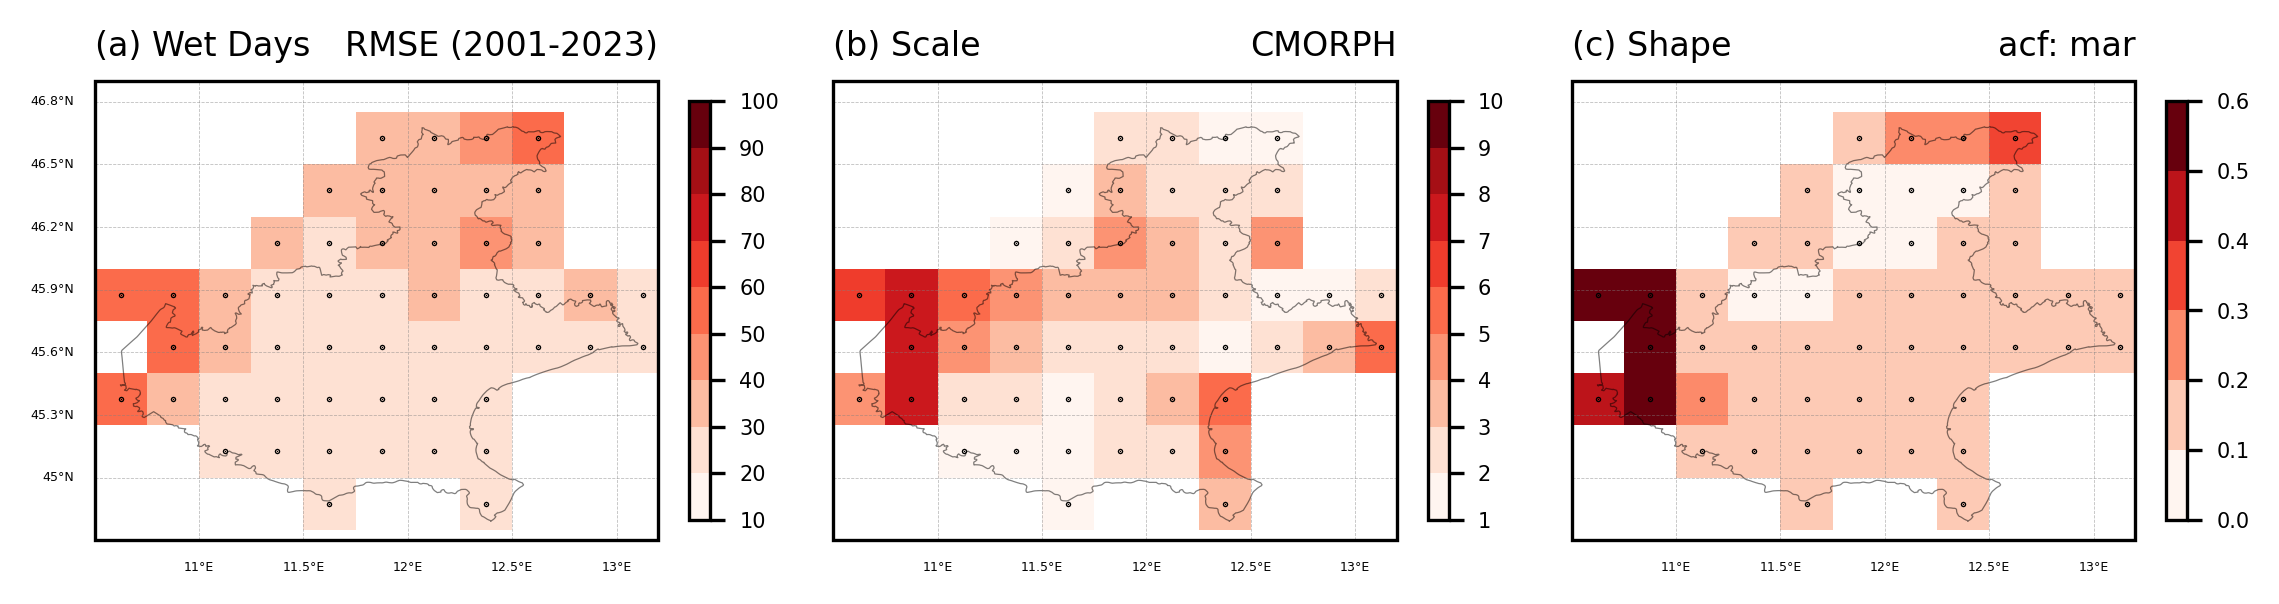

In [21]:
levels_WD = np.arange(10, 110, 10)
norm_WD = mcolors.BoundaryNorm(boundaries=levels_WD, ncolors=256)

levels_SC = np.arange(1, 11, 1)
norm_SC = mcolors.BoundaryNorm(boundaries=levels_SC, ncolors=256)

levels_SH = np.arange(0, 0.7, 0.1)
norm_SH = mcolors.BoundaryNorm(boundaries=levels_SH, ncolors=256)

cmpa_cor1 = plt.cm.Reds
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,3)

# ======================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, RMSE_WD, cmap=cmpa_cor1, norm=norm_WD)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(a) Wet Days', fontsize=8, loc='left')
ax1.set_title(f'RMSE ({yys_cut}-{yye_cut})', fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, RMSE_SC, cmap=cmpa_cor1, norm=norm_SC)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(b) Scale', fontsize=8, loc='left')
ax1.set_title(product, fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, RMSE_SH, cmap=cmpa_cor1, norm=norm_SH)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(c) Shape', fontsize=8, loc='left')
ax1.set_title('acf: mar', fontsize=8, loc='right')

# ======================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.2)

## Spearman Correlation

In [22]:
CORR_WD = CORR_2d(OBS['Wetdays'].values, DATA['DOWN_WD'].values)
CORR_SC = CORR_2d(OBS['Scale'].values, DATA['DOWN_SC'].values)
CORR_SH = CORR_2d(OBS['Shape'].values, DATA['DOWN_SH'].values)

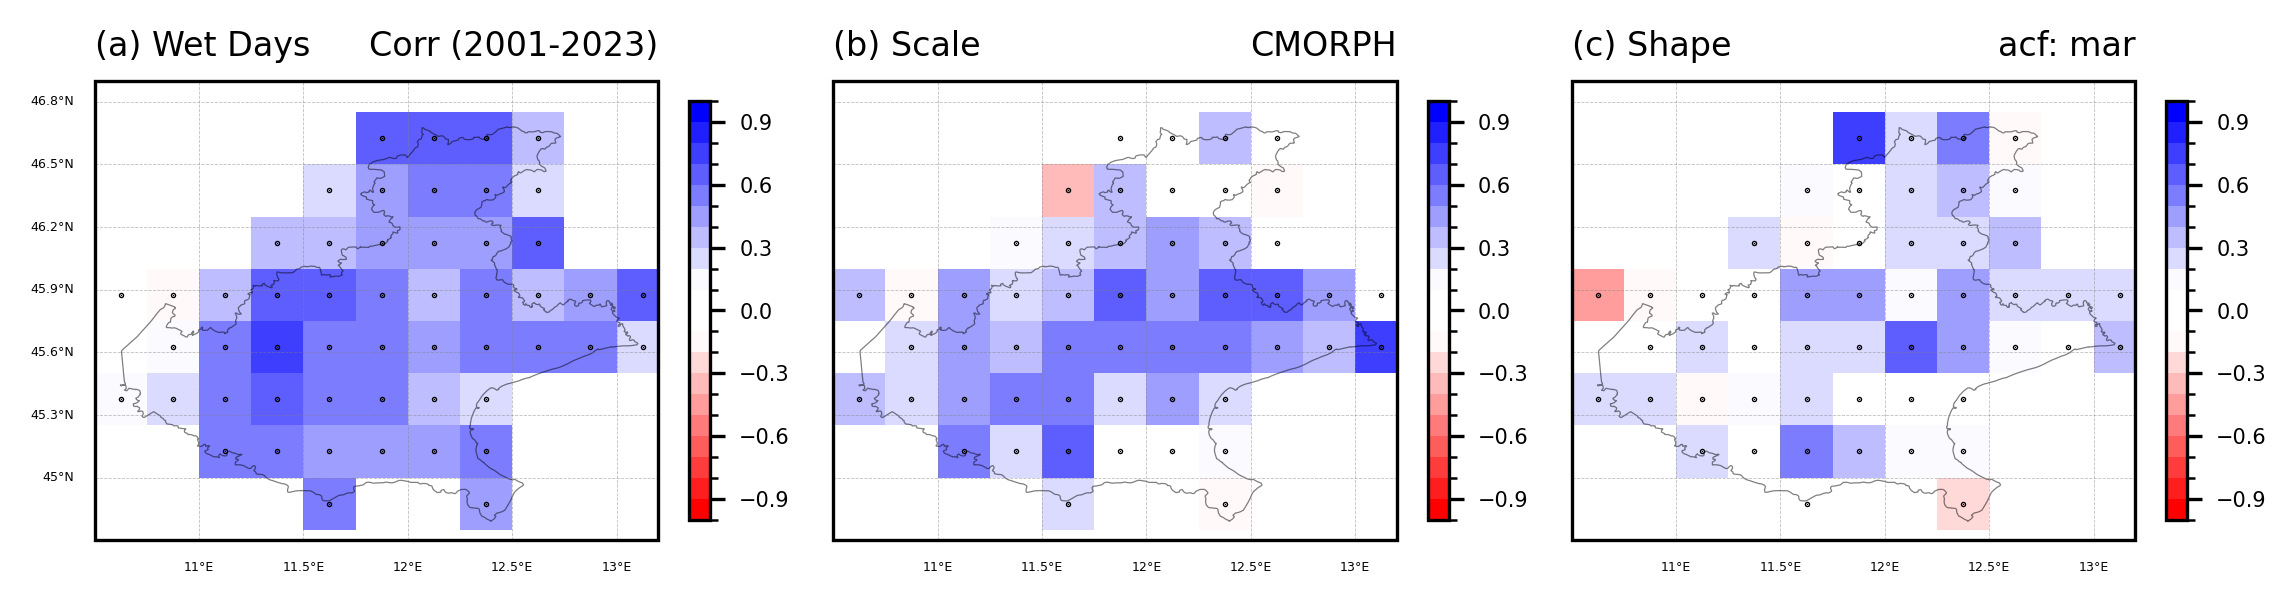

In [23]:
levels = np.arange(-1, 1.1, 0.1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap_cor = plt.cm.bwr_r
cmap_cor = ca.colorbar_middle_white(cmap_cor)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,3)

# ======================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, CORR_WD, cmap=cmap_cor, norm=norm)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(a) Wet Days', fontsize=8, loc='left')
ax1.set_title(f'Corr ({yys_cut}-{yye_cut})', fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, CORR_SC, cmap=cmap_cor, norm=norm)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(b) Scale', fontsize=8, loc='left')
ax1.set_title(product, fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, CORR_SH, cmap=cmap_cor, norm=norm)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(c) Shape', fontsize=8, loc='left')
ax1.set_title('acf: mar', fontsize=8, loc='right')

# ======================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.2)

## Boxplot

In [24]:
import scipy

def mev_fun(y, pr, N, C, W):
    ''' MEV distribution function, to minimize numerically
    for computing quantiles
    Updated version, to include accounting for dry years with 0 events'''
    nyears = N.size
    # mev0f = numzero + np.sum( ( 1-np.exp(-(y/Cn)**Wn ))**Nn) - nyears*pr
    mev0f = np.sum( ( 1-np.exp(-(y/C)**W ))**N) - nyears*pr
    return mev0f

def mev_quant(Fi, x0, N, C, W, thresh=1):
    '''--------------------------------------------------------------------
    computes the MEV quantile for given non exceedance prob. in Fi
    arguments:
    Fi: non exceedance probability (either scalar or array of values)
    x0: starting guess for numerical solution
    N, C, W: Yearly parameters of MEV distribution
    potmode: if True, considers the distributions of value above threshold (default is False)
    (In practice if potmode=True, the distribution of excesses over threshold is computed
    and then from it the cdf is computed for the effective quantile = quant - thresh)
    thresh: threshold for defining ordinary events (default is zero)
    returns:
    quant -> single quantile, or array of quantiles
    flags -> flag = 0 if everything is ok, = 1 if convergence problems
    when It happens, a different x0 should be used.
    ---------------------------------------------------------------------'''
    Fi = np.asarray(Fi)
    is_scalar = False if Fi.ndim > 0 else True
    Fi.shape = (1,)*(1-Fi.ndim) + Fi.shape
    m = np.size(Fi)
    quant = np.zeros(m)
    flags = np.zeros((m), dtype = bool) # flag for the convergence of numerical solver
    for ii in range(m):
        myfun     = lambda y: mev_fun(y,Fi[ii],N,C,W)
        res       = scipy.optimize.fsolve(myfun, x0, full_output = True)
        quant[ii] = res[0]
        info      = res[1]
        fval      = info['fvec']
        if fval > 1e-5:
            print('mevd_quant:: ERROR - fsolve does not work -  change x0')
            flags[ii] = 1
    quant = quant + thresh
    quant  = quant if not is_scalar else quant[0]
    flags  = flags if not is_scalar else flags[0]
    return quant, flags

In [96]:
colors_manual = [
        (0.42000000000000004, 0.6333333333333333, 0.8466666666666667, 0.5),
        (0.7400000000000001, 0.31333333333333335, 0.7400000000000001, 0.5),
        (0.5800000000000001, 0.9, 0.3666666666666667, 0.5)]

### IMERG AND OBS

In [104]:
data_dir = os.path.join(dir_base,f'VENETO_WEIBULL_IMERG_2001_2023.nc')
print(f'IMERG load: {data_dir}')
DATA = xr.open_dataset(data_dir)

nlat = len(DATA['lat'])
nlon = len(DATA['lon'])
ntime = len(DATA['time'])

IMERG_WD = np.reshape(DATA['DOWN_WD'].values,ntime*nlat*nlon)
IMERG_WD = IMERG_WD[~np.isnan(IMERG_WD)]

IMERG_SC = np.reshape(DATA['DOWN_SC'].values,ntime*nlat*nlon)
IMERG_SC = IMERG_SC[~np.isnan(IMERG_SC)]

IMERG_SH = np.reshape(DATA['DOWN_SH'].values,ntime*nlat*nlon)
IMERG_SH = IMERG_SH[~np.isnan(IMERG_SH)]

# ==================================================================================
OBS_dir = os.path.join(dir_base,f'VENETO_WEIBULL_OBS_IMERG_1981_2023.nc')
print(f'OBS load: {OBS_dir}')
OBS = xr.open_dataset(OBS_dir)
OBS = OBS.sel(time=OBS.time.dt.year.isin([np.arange(yys_cut,yye_cut+1)]))

nlat = len(OBS['lat'])
nlon = len(OBS['lon'])
ntime = len(OBS['time'])

OBS_WD_clear = np.reshape(OBS['Wetdays'].values,ntime*nlat*nlon)
OBS_WD_clear = OBS_WD_clear[~np.isnan(OBS_WD_clear)]

OBS_SC_clear = np.reshape(OBS['Scale'].values,ntime*nlat*nlon)
OBS_SC_clear = OBS_SC_clear[~np.isnan(OBS_SC_clear)]

OBS_SH_clear = np.reshape(OBS['Shape'].values,ntime*nlat*nlon)
OBS_SH_clear = OBS_SH_clear[~np.isnan(OBS_SH_clear)]

IMERG load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_IMERG_2001_2023.nc
OBS load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_OBS_IMERG_1981_2023.nc


[Text(0.0, 0, 'OBS'), Text(0.5, 0, 'IMERG')]

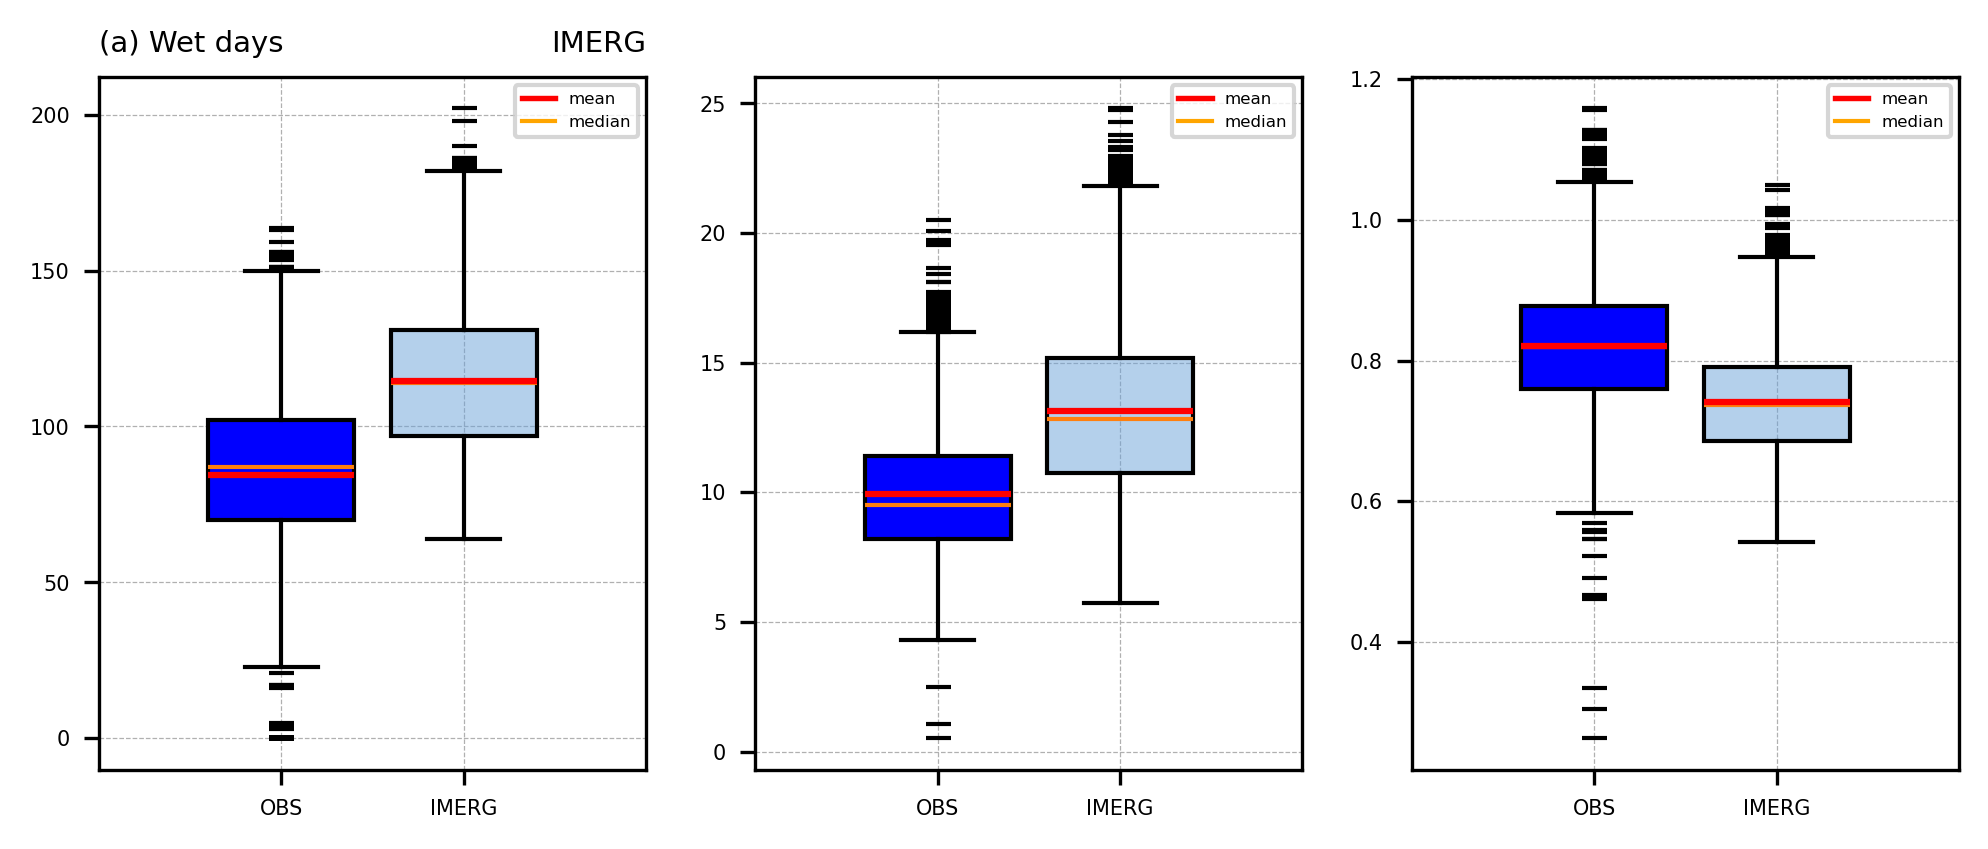

In [ ]:
outliers = True

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)
plt.style.use('default')

# =======================================================================================
ax1 = plt.subplot(gs[0, 0])
box = ax1.boxplot(OBS_WD_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_WD,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

ax1.set_title('(a) Wet days', fontsize=7, loc='left')
ax1.set_title('IMERG', fontsize=7, loc='right')

# =======================================================================================
ax1 = plt.subplot(gs[0, 1])
box = ax1.boxplot(OBS_SC_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_SC,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

# =======================================================================================
ax1 = plt.subplot(gs[0, 2])
box = ax1.boxplot(OBS_SH_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_SH,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

# =======================================================================================

### IMERG 0.25x0.25 AND OBS

In [101]:
data_dir = os.path.join(dir_base,f'VENETO_WEIBULL_IMERG_025x025_2001_2023.nc')
print(f'IMERG 0.25x0.25 load: {data_dir}')
DATA = xr.open_dataset(data_dir)

nlat = len(DATA['lat'])
nlon = len(DATA['lon'])
ntime = len(DATA['time'])

IMERG_025_WD = np.reshape(DATA['DOWN_WD'].values,ntime*nlat*nlon)
IMERG_025_WD = IMERG_025_WD[~np.isnan(IMERG_025_WD)]

IMERG_025_SC = np.reshape(DATA['DOWN_SC'].values,ntime*nlat*nlon)
IMERG_025_SC = IMERG_025_SC[~np.isnan(IMERG_025_SC)]

IMERG_025_SH = np.reshape(DATA['DOWN_SH'].values,ntime*nlat*nlon)
IMERG_025_SH = IMERG_025_SH[~np.isnan(IMERG_025_SH)]

# ==================================================================================
OBS_dir = os.path.join(dir_base,f'VENETO_WEIBULL_OBS_IMERG_025x025_1981_2023.nc')
print(f'OBS load: {OBS_dir}')
OBS = xr.open_dataset(OBS_dir)
OBS = OBS.sel(time=OBS.time.dt.year.isin([np.arange(yys_cut,yye_cut+1)]))

nlat = len(OBS['lat'])
nlon = len(OBS['lon'])
ntime = len(OBS['time'])

OBS_WD_clear = np.reshape(OBS['Wetdays'].values,ntime*nlat*nlon)
OBS_WD_clear = OBS_WD_clear[~np.isnan(OBS_WD_clear)]

OBS_SC_clear = np.reshape(OBS['Scale'].values,ntime*nlat*nlon)
OBS_SC_clear = OBS_SC_clear[~np.isnan(OBS_SC_clear)]

OBS_SH_clear = np.reshape(OBS['Shape'].values,ntime*nlat*nlon)
OBS_SH_clear = OBS_SH_clear[~np.isnan(OBS_SH_clear)]

IMERG 0.25x0.25 load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_IMERG_025x025_2001_2023.nc
OBS load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_OBS_IMERG_025x025_1981_2023.nc


[Text(0.0, 0, 'OBS'), Text(0.5, 0, 'IMERG')]

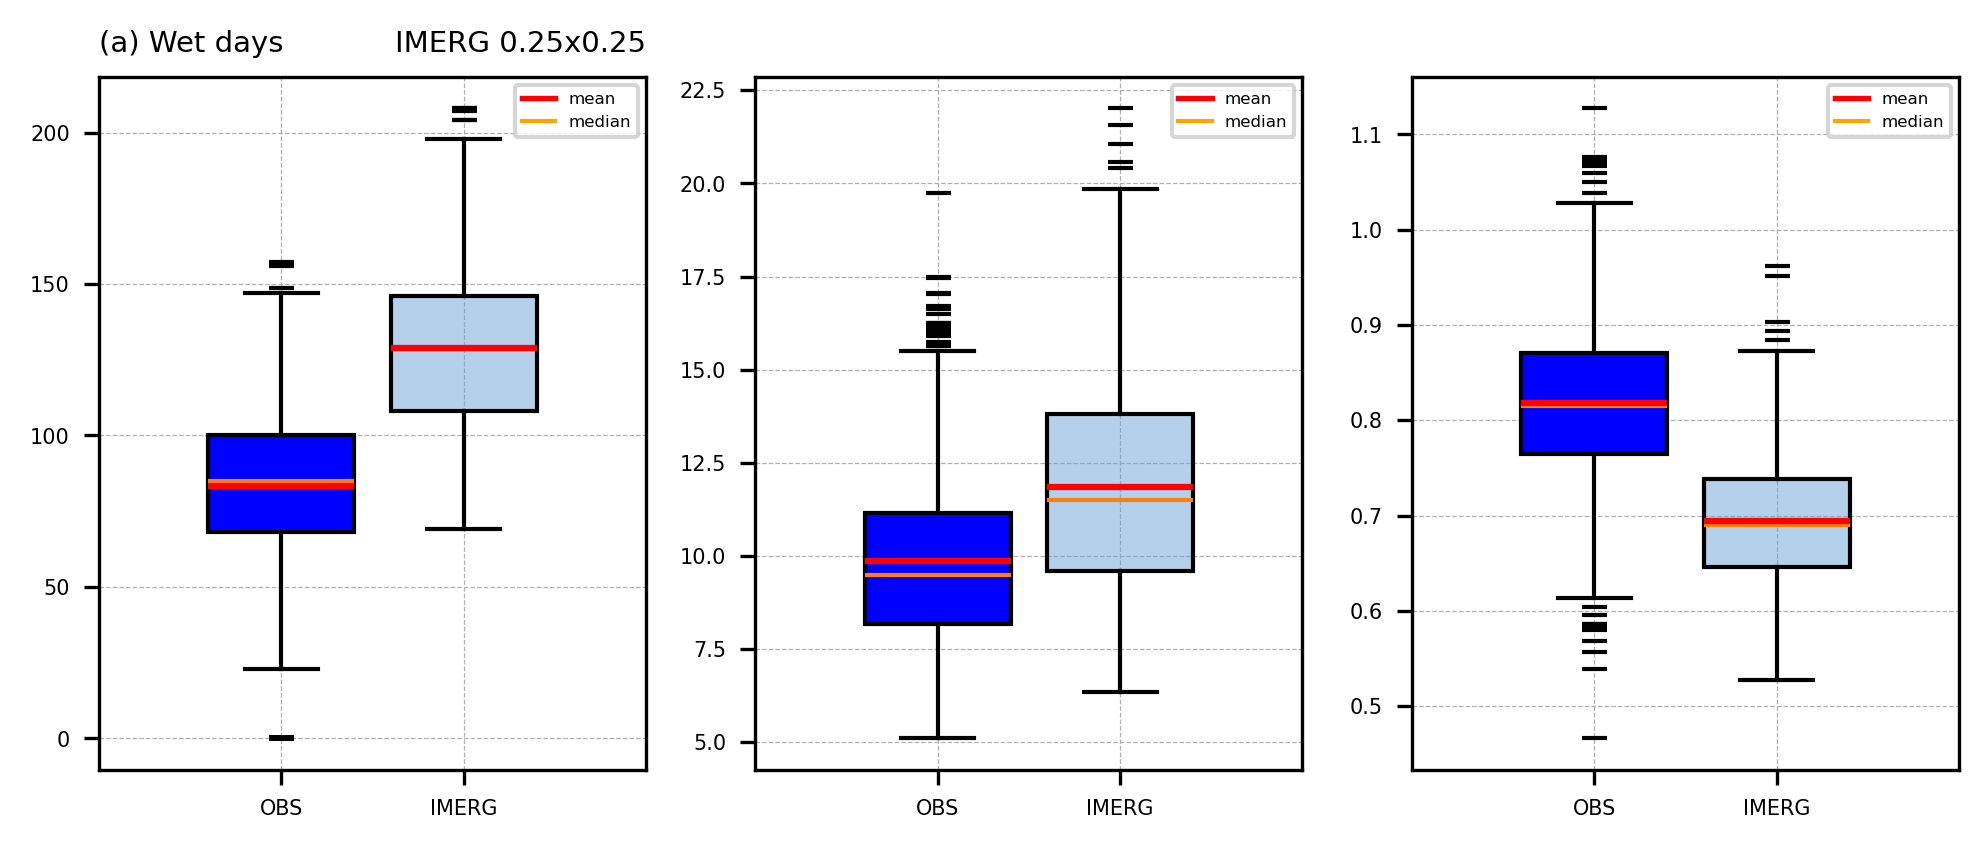

In [102]:
outliers = True

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)
plt.style.use('default')

# =======================================================================================
ax1 = plt.subplot(gs[0, 0])
box = ax1.boxplot(OBS_WD_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_025_WD,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

ax1.set_title('(a) Wet days', fontsize=7, loc='left')
ax1.set_title('IMERG 0.25x0.25', fontsize=7, loc='right')

# =======================================================================================
ax1 = plt.subplot(gs[0, 1])
box = ax1.boxplot(OBS_SC_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_025_SC,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

# =======================================================================================
ax1 = plt.subplot(gs[0, 2])
box = ax1.boxplot(OBS_SH_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_025_SH,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

# =======================================================================================


### CMORPH

In [90]:
data_dir = os.path.join(dir_base,f'VENETO_WEIBULL_CMORPH_1998_2023.nc')
print(f'CMORPH load: {data_dir}')
DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yys_cut,yye_cut+1)]))

nlat = len(DATA['lat'])
nlon = len(DATA['lon'])
ntime = len(DATA['time'])

CMORPH_WD = np.reshape(DATA['DOWN_WD'].values,ntime*nlat*nlon)
CMORPH_WD = CMORPH_WD[~np.isnan(CMORPH_WD)]

CMORPH_SC = np.reshape(DATA['DOWN_SC'].values,ntime*nlat*nlon)
CMORPH_SC = CMORPH_SC[~np.isnan(CMORPH_SC)]

CMORPH_SH = np.reshape(DATA['DOWN_SH'].values,ntime*nlat*nlon)
CMORPH_SH = CMORPH_SH[~np.isnan(CMORPH_SH)]

# ==================================================================================
OBS_dir = os.path.join(dir_base,f'VENETO_WEIBULL_OBS_CMORPH_1981_2023.nc')
print(f'OBS load: {OBS_dir}')
OBS = xr.open_dataset(OBS_dir)
OBS = OBS.sel(time=OBS.time.dt.year.isin([np.arange(yys_cut,yye_cut+1)]))

nlat = len(OBS['lat'])
nlon = len(OBS['lon'])
ntime = len(OBS['time'])

OBS_WD_clear = np.reshape(OBS['Wetdays'].values,ntime*nlat*nlon)
OBS_WD_clear = OBS_WD_clear[~np.isnan(OBS_WD_clear)]

OBS_SC_clear = np.reshape(OBS['Scale'].values,ntime*nlat*nlon)
OBS_SC_clear = OBS_SC_clear[~np.isnan(OBS_SC_clear)]

OBS_SH_clear = np.reshape(OBS['Shape'].values,ntime*nlat*nlon)
OBS_SH_clear = OBS_SH_clear[~np.isnan(OBS_SH_clear)]

CMORPH load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_CMORPH_1998_2023.nc
OBS load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_OBS_CMORPH_1981_2023.nc


[Text(0.0, 0, 'OBS'), Text(0.5, 0, 'IMERG')]

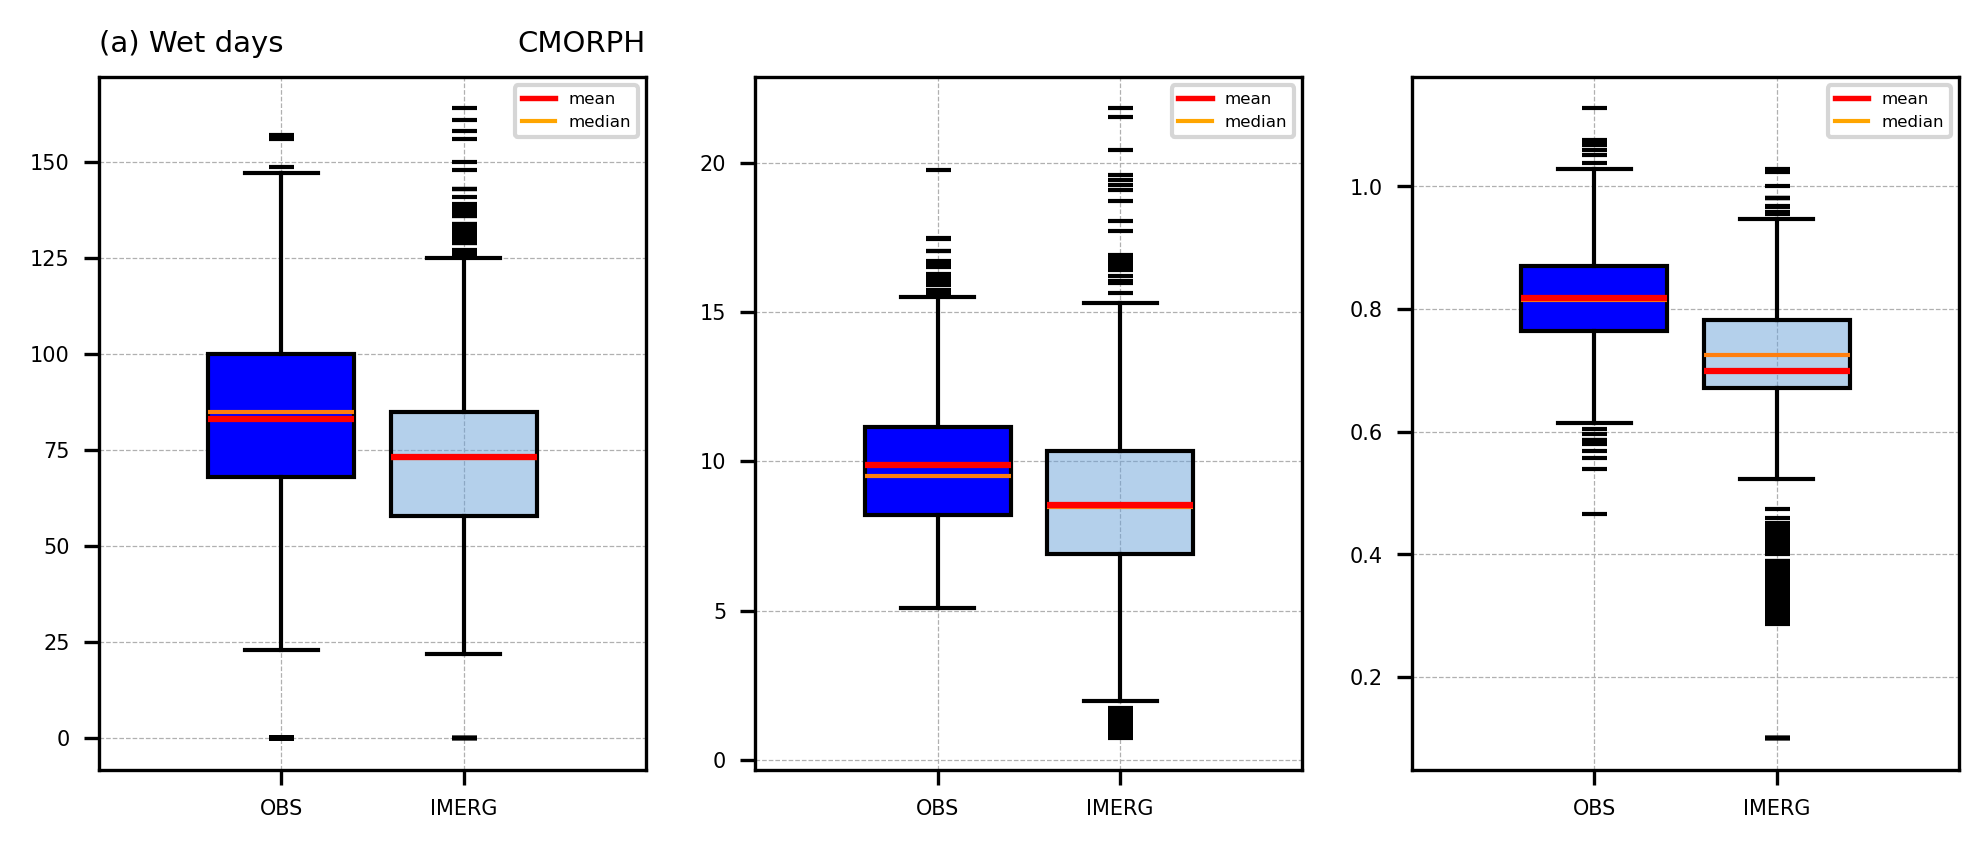

In [100]:
outliers = True

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)
plt.style.use('default')

# =======================================================================================
ax1 = plt.subplot(gs[0, 0])
box = ax1.boxplot(OBS_WD_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(CMORPH_WD,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

ax1.set_title('(a) Wet days', fontsize=7, loc='left')
ax1.set_title('CMORPH', fontsize=7, loc='right')

# =======================================================================================
ax1 = plt.subplot(gs[0, 1])
box = ax1.boxplot(OBS_SC_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(CMORPH_SC,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

# =======================================================================================
ax1 = plt.subplot(gs[0, 2])
box = ax1.boxplot(OBS_SH_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(CMORPH_SH,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

# =======================================================================================

Text(0.0, 1.0, '(c) Shape')

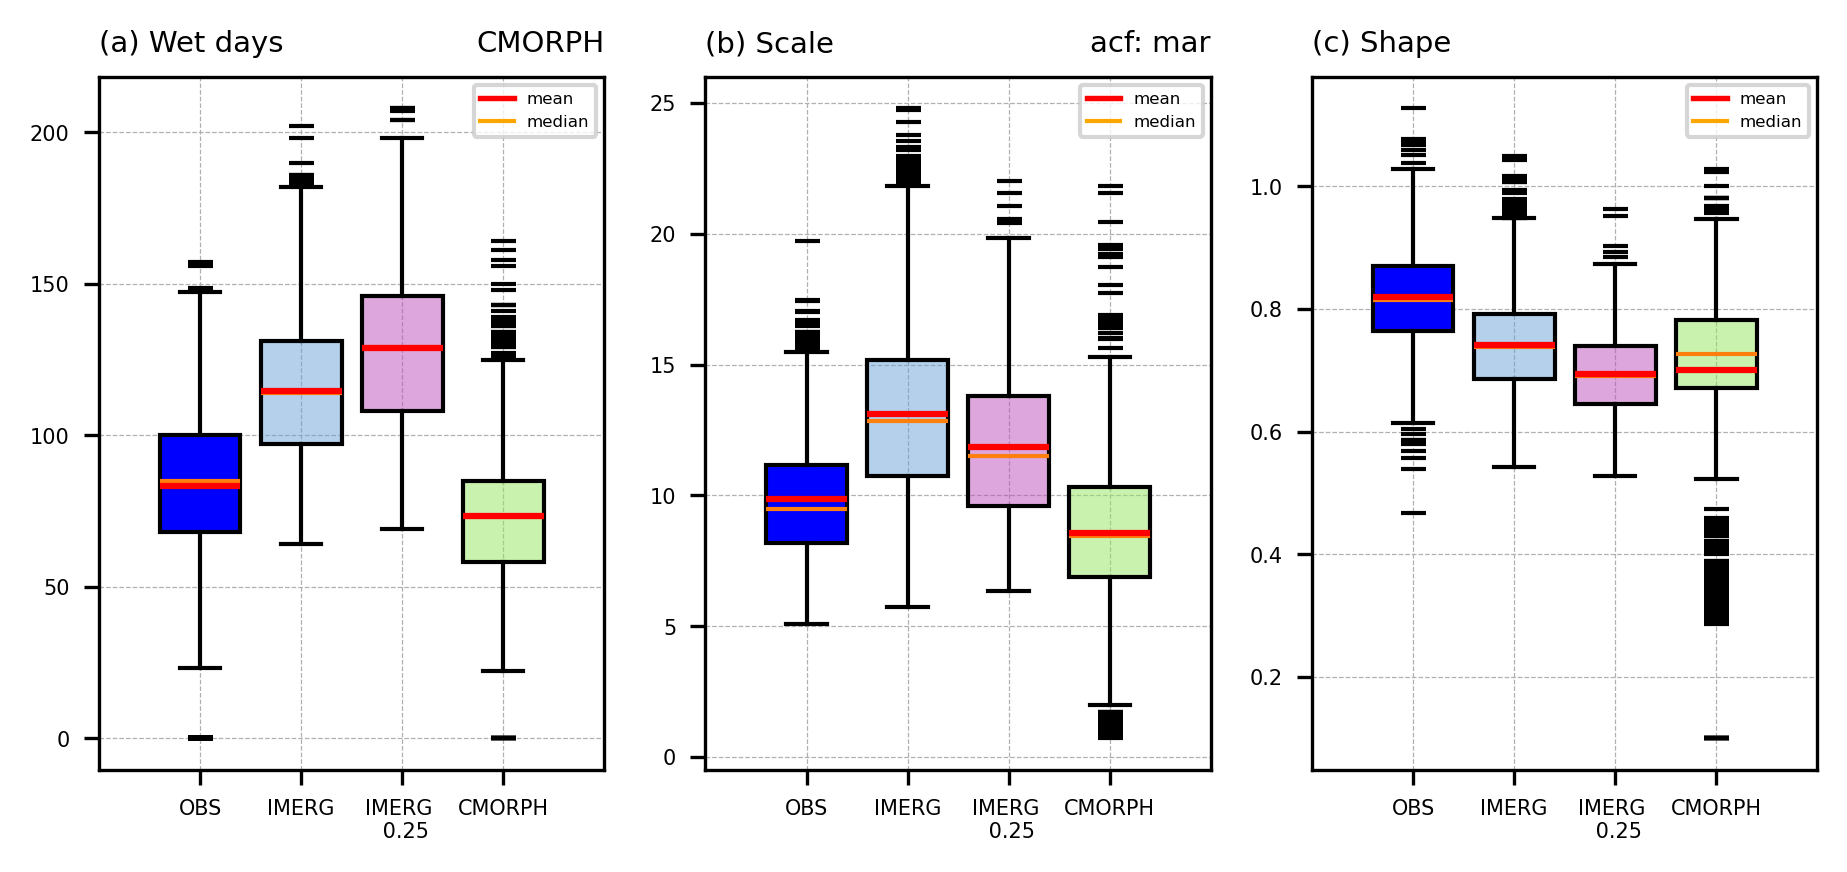

In [51]:
outliers = True

fig = plt.figure(figsize=(10,3),dpi=300)
gs = gridspec.GridSpec(1,4)
plt.style.use('default')

# =======================================================================================
ax1 = plt.subplot(gs[0, 0])
box = ax1.boxplot(OBS_WD_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_WD,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_025_WD,positions=[1],
widths=0.4,boxprops=dict(facecolor=colors_manual[1]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(CMORPH_WD,positions=[1.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[2]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5, 1, 1.5])
ax1.set_xticklabels(['OBS', 'IMERG', 'IMERG \n 0.25', 'CMORPH'], fontsize=5)

ax1.set_title('(a) Wet days', fontsize=7, loc='left')
ax1.set_title(product, fontsize=7, loc='right')

# =======================================================================================
ax1 = plt.subplot(gs[0, 1])
box = ax1.boxplot(OBS_SC_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_SC,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_025_SC,positions=[1],
widths=0.4,boxprops=dict(facecolor=colors_manual[1]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(CMORPH_SC,positions=[1.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[2]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5, 1, 1.5])
ax1.set_xticklabels(['OBS', 'IMERG', 'IMERG \n 0.25', 'CMORPH'], fontsize=5)

ax1.set_title('(b) Scale', fontsize=7, loc='left')
ax1.set_title('acf: mar', fontsize=7, loc='right')

# =======================================================================================
ax1 = plt.subplot(gs[0, 2])
box = ax1.boxplot(OBS_SH_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_SH,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_025_SH,positions=[1],
widths=0.4,boxprops=dict(facecolor=colors_manual[1]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(CMORPH_SH,positions=[1.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[2]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5, 1, 1.5])
ax1.set_xticklabels(['OBS', 'IMERG', 'IMERG \n 0.25', 'CMORPH'], fontsize=5)

ax1.set_title('(c) Shape', fontsize=7, loc='left')

## MEV quantile for given non exceedance probability

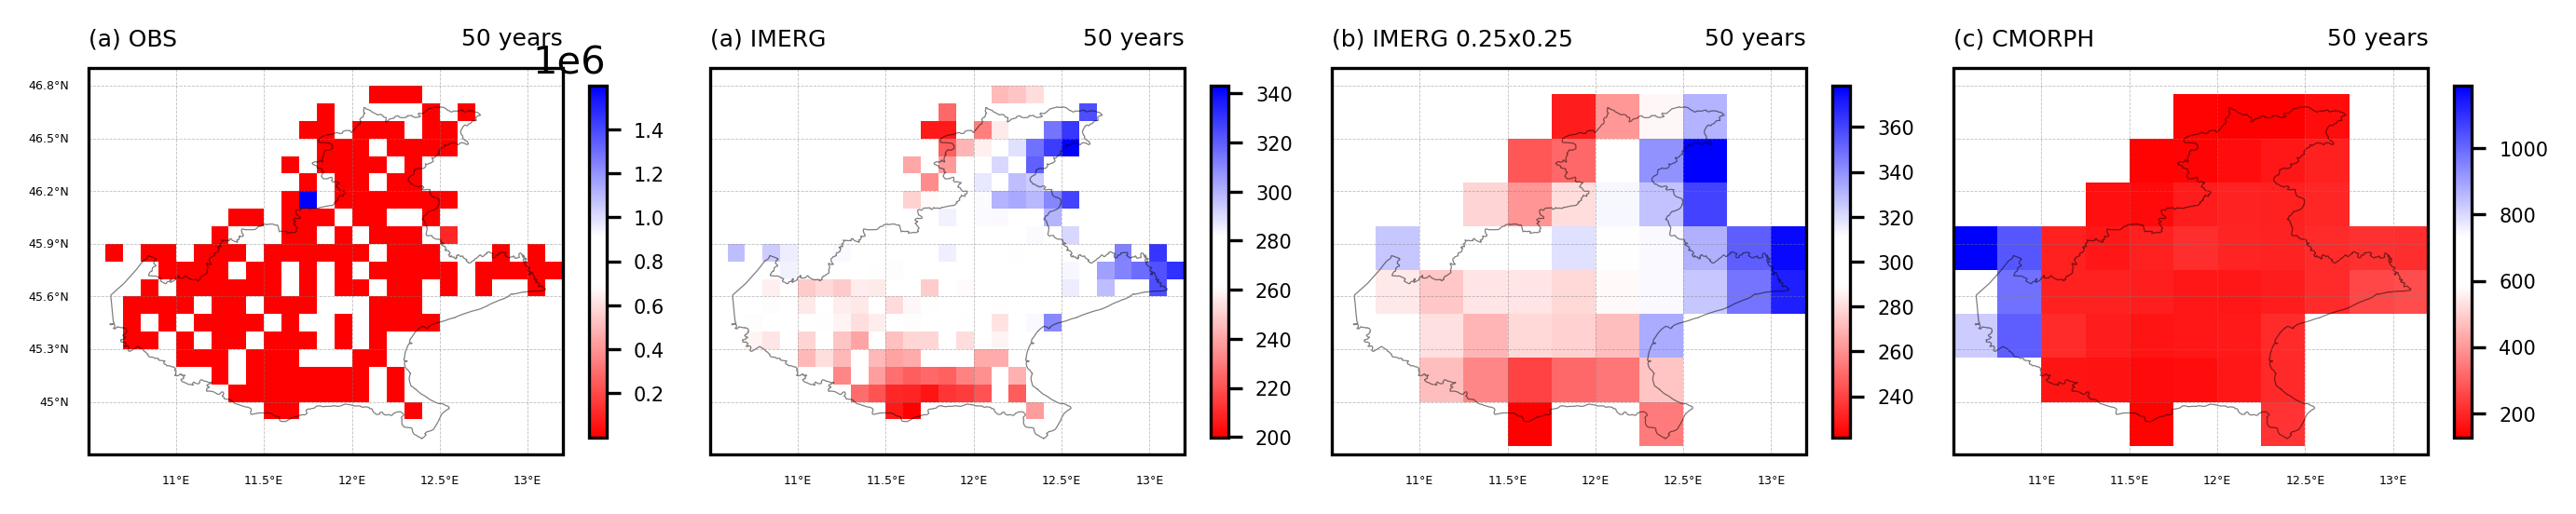

In [79]:
levels = np.arange(-1, 1.1, 0.1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap_cor = plt.cm.bwr_r
cmap_cor = ca.colorbar_middle_white(cmap_cor)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(11,4),dpi=300)
gs = gridspec.GridSpec(1,4)

# ======================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(OBS_lon2d, OBS_lat2d, OBS_Q[6,:,:], cmap=cmap_cor)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(a) OBS', fontsize=6, loc='left')
ax1.set_title(f'{Tr[6]} years', fontsize=6, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(IMERG_lon2d, IMERG_lat2d, IMERG_Q[6,:,:], cmap=cmap_cor)
# ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(a) IMERG', fontsize=6, loc='left')
ax1.set_title(f'{Tr[6]} years', fontsize=6, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(IMERG_025_lon2d, IMERG_025_lat2d, IMERG_025_Q[6,:,:], cmap=cmap_cor)
# ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(b) IMERG 0.25x0.25', fontsize=6, loc='left')
ax1.set_title(f'{Tr[6]} years', fontsize=6, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 3], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(CMORPH_lon2d, CMORPH_lat2d, CMORPH_Q[6,:,:], cmap=cmap_cor)
# ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(c) CMORPH', fontsize=6, loc='left')
ax1.set_title(f'{Tr[6]} years', fontsize=6, loc='right')

# ======================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.2)

In [55]:
mask.shape

(12, 16)